In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob

from lifelines import KaplanMeierFitter
## import gaussian1d
from scipy.ndimage import gaussian_filter1d
sys.path.append(os.path.abspath(os.path.join('../..')))
# sys.path.append('../..')
from train_risk_regression_model_with_recon_task import get_dataset, get_model, DL_single_run

This jupyternote book performs 
1. collect the trained models under a two-fold cross validation. e.g., for two-fold validaiton, two models should get for one run in order to get estimated risk scores for all the subjects in the dataset.
2. for a test subject, get averaged risk score, attentionmaps using those models trained without seeing this subject
3. plot the risk score distributions over the whole trainng set
4. identify the risk thresholding based on the statistics obtained from the statistics
5. use the threshold to identify low/high risk groups.
6. pick up the one with highest risk score and visualize the attention maps
7. pick up some examples in the low and high risk group and visualize it.


In [2]:
## initialize dataset
# task_name ="HYP_with_HF_event"
task_name ="MI_with_HF_event"

# X, y = get_dataset(task_name)
# low_risk_index = 319
# high_risk_index = [702,783,237]
# task_name ="HYP_with_HF_event"
# task_name ="HYP_with_HF_event"
X,y =get_dataset(dataset_name = task_name)
# ecg_high_risk  = X[702


/home/engs2522/project/LLM-ECG-Dual-Attention
load signal and event data from default path
load MI_with_HF_event
load x,y from the given path /home/engs2522/project/LLM-ECG-Dual-Attention/data/ukb/MI_to_HF_survival_data/ecg_data.npy /home/engs2522/project/LLM-ECG-Dual-Attention/data/ukb/MI_to_HF_survival_data/y_status_duration.npy
input ecg shape (800, 12, 608)
status, duration, eid (800, 3)


In [3]:
## plot risk score distribution
from sklearn.model_selection import train_test_split, StratifiedKFold
from pathlib import Path
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# Initialize lists to store predictions
val_c_index_list = []
y_status_list = y[:,0]
i =0
y_eid_list = y[:,-1]
# print(y_eid_list)

## get the text report from xml file
def get_report(search_index, y_eid_list, ukb_data_path ="data/ukb/ecg_report.csv"):
    search_eid = y_eid_list[search_index]
    ecg_file_finder_df = pd.read_csv(ukb_data_path, index_col=0)
    diagnosis_statement =ecg_file_finder_df.loc[search_eid]["diagnosis"]
    conclusion_statement = ecg_file_finder_df.loc[search_eid]["conclusion"]
    return diagnosis_statement, conclusion_statement

project_root_path = Path(os.path.abspath("__file__")).parents[2]
print(project_root_path)
diagnosis_statement, conclusion_statement = get_report(702, y_eid_list,os.path.join(project_root_path,"data/ukb/ecg_report.csv"))
print (diagnosis_statement)
print(conclusion_statement)

/home/engs2522/project/LLM-ECG-Dual-Attention
['Normal sinus rhythm', 'Left bundle branch block', 'Abnormal ECG', '---', 'Arrhythmia results of the full-disclosure ECG', 'QRS Complexes: 16,   PSVC: 1']
['Normal sinus rhythm', 'Left bundle branch block', 'Abnormal ECG', '---', 'Arrhythmia results of the full-disclosure ECG', 'QRS Complexes: 16,   PSVC: 1']


In [4]:
y_status_list = y[:,0]
seed_list = [42]
latent_code_dim =512
seed_y_score_list = []
risk_scores = []
for seed in seed_list:
    lead_attention_list = []
    time_attention_leadwise_list = {}
    y_total_test=[]
    test_indices_list=[]
    total_risk_score=[]
    lead_attention_aggregated=None
    for cval, (train_indices, test_indices) in enumerate(kf.split(X, y_status_list)):
        x_train, y_train = X[train_indices], y[train_indices]
        x_test, y_test = X[test_indices], y[test_indices]
            ## find the best model path:
        model_dir = os.path.join(project_root_path, f"result/train_survival_net_{task_name}_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/{seed}/cval_{cval}/")
        print(model_dir)
        best_model_path_list =glob.glob(model_dir+"best_model*_lr_*.pth")
        ## remove path with alpha
        if len(best_model_path_list)==0:
            raise ValueError("No model found")
        else:
            if len(best_model_path_list) >1:
                print (best_model_path_list)

                best_model_path_list = [x for x in best_model_path_list if "alpha" not in x]
                c_index_list = [float((x.split("/")[-1]).split("_")[4]) for x in best_model_path_list]
                highest_one = np.argmax(c_index_list)
                best_model_path  = best_model_path_list[highest_one]
            else:
                best_model_path = best_model_path_list[0]
        print(best_model_path)
        trainer, survival_model = DL_single_run(x_train, y_train,  
                    model_name = "ECG_attention",
                    checkpoint_path="",
                    batch_size = 200,
                    train_from_scratch=True,
                    freeze_encoder=False, test_only=True, 
                    test_checkpoint_path = best_model_path,
                    latent_code_dim=latent_code_dim)
        survival_model.freeze()
        X_test= torch.from_numpy(x_test).float().to(survival_model.device)

        with torch.inference_mode():
            log_risk_score,_ = survival_model(X_test)
            ## get last layer hidden feature for visualization
            lead_attention_map, time_attention_map = survival_model.encoder.get_attention()
            print ("last hidden shape", lead_attention_map.shape)
            print ("time attention shape", time_attention_map[0].shape)

        lead_attention_list.append(lead_attention_map.cpu().detach().numpy())
        for i in range(len(time_attention_map)):
            if i not in time_attention_leadwise_list:
                time_attention_leadwise_list[i] = []
            time_attention_leadwise_list[i].append(time_attention_map[i].cpu().detach().numpy())
        total_risk_score.append(log_risk_score.cpu().detach().numpy())
        test_indices_list.append(test_indices)
    test_indices_flatten = np.concatenate(test_indices_list)
    total_risk_score_flatten = np.concatenate(total_risk_score)
     ## sort the risk score back to the original order
    total_risk_score_sorted = total_risk_score_flatten[np.argsort(test_indices_flatten)]
    
    lead_attention_flatten = np.concatenate(lead_attention_list)
    lead_attention_sorted = lead_attention_flatten[np.argsort(test_indices_flatten)]
    if lead_attention_aggregated is None:
        lead_attention_aggregated = lead_attention_sorted
    else:
        lead_attention_aggregated += lead_attention_sorted
    time_attantion_dict_flatten = {}
    for i,time_list in time_attention_leadwise_list.items():
        concate_list =  np.concatenate(time_list)
        time_attantion_dict_flatten[i] =concate_list[np.argsort(test_indices_flatten)]
   

/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_0/best_model_c_index_0.4943_lr_3.981071705534972e-07.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


last hidden shape torch.Size([400, 12, 12])
time attention shape torch.Size([400, 19, 19])
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_1/best_model_c_index_0.6701_lr_3.5481338923357546e-06.pth
no linear layer
last hidden shape torch.Size([400, 12, 12])
time attention shape torch.Size([400, 19, 19])


median risk score:  -0.24505895


/tmp/ipykernel_22179/1082493144.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total_risk_score_sorted, label="risk score distribution")


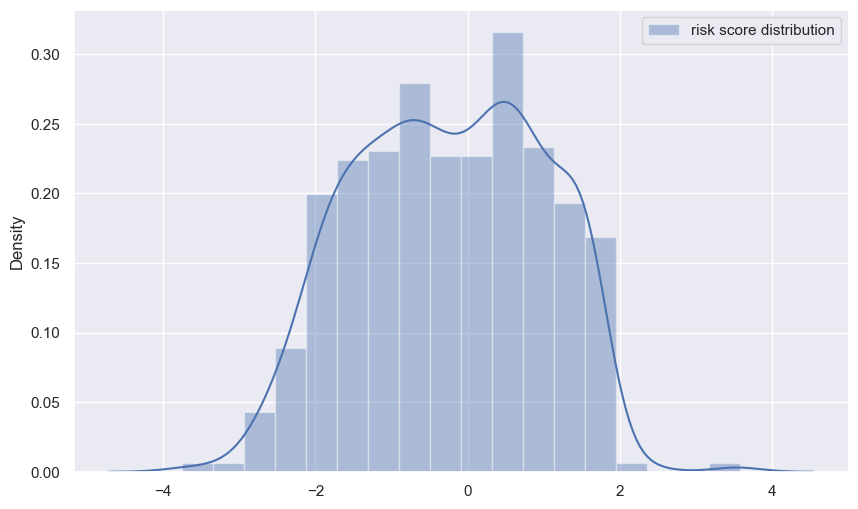

In [5]:
plt.figure(figsize=(10,6))
sns.distplot(total_risk_score_sorted, label="risk score distribution")
plt.legend()
## find the median risk score
median_risk_score = np.median(total_risk_score_sorted)
print("median risk score: ", median_risk_score)

(12, 12)


Text(0.5, 0.98, 'MI_with_HF_event')

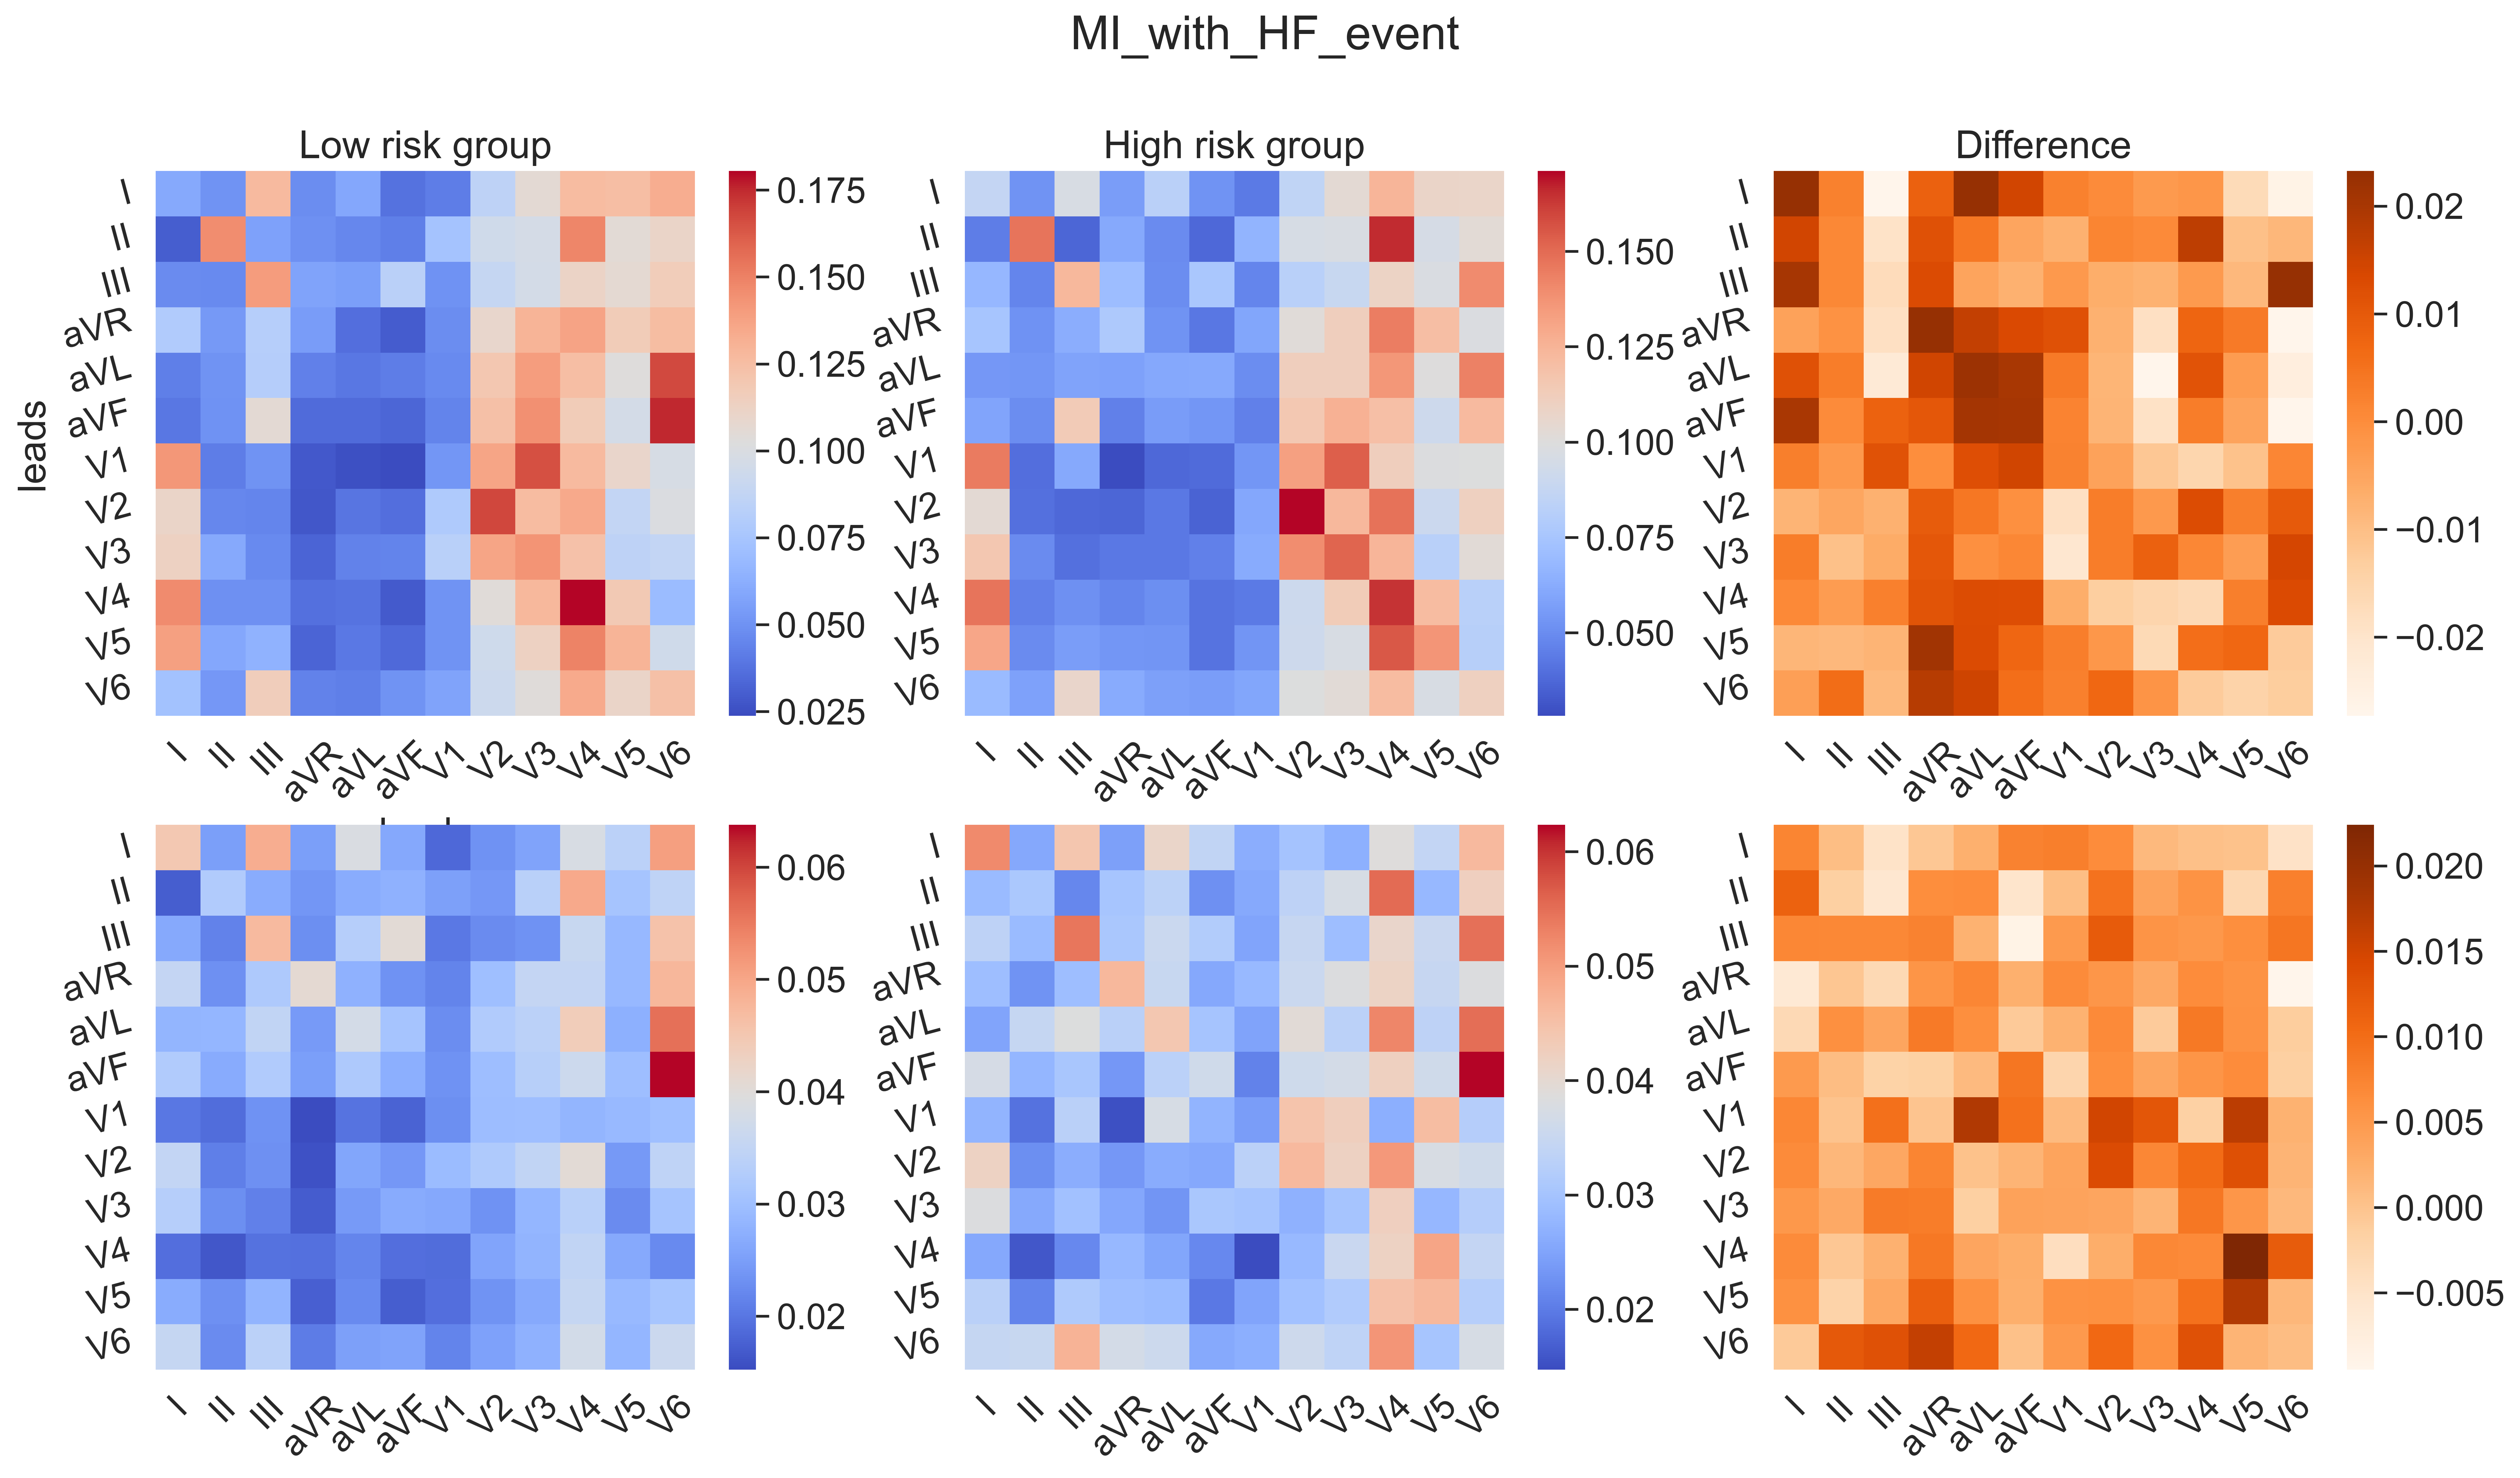

In [23]:
## summarize the lead attention maps for high risk groups and low risk groups
sns.set(font_scale=1.5)
if "MI" in task_name:
    median_risk_score = np.percentile(total_risk_score_sorted, 96)
elif "HYP" in task_name:
    median_risk_score = np.percentile(total_risk_score_sorted, 98)

high_risk_indices = np.where(total_risk_score_sorted>=median_risk_score)[0]
low_risk_indices = np.where(total_risk_score_sorted<median_risk_score)[0]
lead_attention_low_risk = lead_attention_aggregated[low_risk_indices]
average_attention_low_risk = np.mean(lead_attention_low_risk, axis=0)
std_attention_low_risk = np.std(lead_attention_low_risk, axis=0)

average_attention_high_risk  = np.mean(lead_attention_aggregated[high_risk_indices], axis=0)
std_attention_high_risk = np.std(lead_attention_aggregated[high_risk_indices], axis=0)
print(average_attention_low_risk.shape)

## plot heatmap: mean and std of the attention maps
fig, axes = plt.subplots(2,3, figsize=(19,10),dpi=500)
x_ticks = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
g = sns.heatmap(average_attention_low_risk, ax =axes[0,0],cmap="coolwarm", xticklabels=x_ticks, yticklabels=x_ticks)
g = sns.heatmap(std_attention_low_risk, ax =axes[1,0],cmap="coolwarm", xticklabels=x_ticks, yticklabels=x_ticks)

g = sns.heatmap(average_attention_high_risk, ax =axes[0,1],cmap="coolwarm", xticklabels=x_ticks, yticklabels=x_ticks)
g = sns.heatmap(std_attention_high_risk, ax =axes[1,1],cmap="coolwarm", xticklabels=x_ticks, yticklabels=x_ticks)

## difference map
g = sns.heatmap(average_attention_high_risk-average_attention_low_risk, ax =axes[0,2],robust=True, center=0, cmap="Oranges", xticklabels=x_ticks, yticklabels=x_ticks)
g = sns.heatmap(std_attention_high_risk-std_attention_low_risk, ax =axes[1,2],cmap="Oranges", xticklabels=x_ticks, yticklabels=x_ticks)

## rotate the xticklabels
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=15)
## rotate the yticklabels

axes[0,0].set_title("Low risk group")
# axes[1,0].set_title("low risk group")
axes[0,1].set_title("High risk group")
axes[0,2].set_title("Difference")
# axes[1,1].set_title("high risk group: ")
axes[0,0].set_ylabel("leads")
axes[0,0].set_xlabel("leads")
plt.suptitle(task_name)



In [7]:
y[:,2]

array([1007100, 1011223, 1013662, 1025631, ..., 5946901, 5963624, 5978979, 6021837])

In [8]:
df = pd.DataFrame(np.array([y[:,0],y[:,1],y[:,2],total_risk_score_sorted[:,0]]).T, columns=["status","time","eid","risk_score"])
print("number of patients: ", len(df.eid.unique()))
low_risk_df = df[df.status==0].sort_values(by="risk_score")
subject_indice =0
print("low risk group: ")
print("low risk id", low_risk_df.iloc[0:3].eid)
low_risk_index = np.argmax(y[:,2]==int(low_risk_df.iloc[0].eid))
print("low_risk_index", low_risk_index)
print("low risk time", low_risk_df.iloc[0].time)

print("low risk score", low_risk_df.iloc[0].risk_score)
print("high risk group: ")
high_risk_df = df[df.status==1]
high_risk_df = high_risk_df.sort_values(by=["risk_score","time"], ascending=[False,True])
high_risk_df.head(10)
print("high risk id", high_risk_df.iloc[0:3].eid)
high_risk_index = np.argmax(y[:,2]==int(high_risk_df.iloc[0].eid))
print("high_risk_index", high_risk_index)
print("high risk score eid", high_risk_df.iloc[0].eid)
print("high risk score time", high_risk_df.iloc[0].time)
print("high risk score:", high_risk_df.iloc[0].risk_score)


number of patients:  800
low risk group: 
low risk id 625    4886783.0
286    2852292.0
650    5052572.0
Name: eid, dtype: float64
low_risk_index 625
low risk time 47.0
low risk score -3.75042986869812
high risk group: 
high risk id 572    4524745.0
783    5880752.0
702    5363922.0
Name: eid, dtype: float64
high_risk_index 572
high risk score eid 4524745.0
high risk score time 15.0
high risk score: 1.609407901763916


In [9]:
## find receptive field for the hidden feature layer, we will use gradient-based approach
import torch.nn as nn
def init_network(model, init_weights=True):
    survival_model.train()
    for name,module in model.named_modules():
        # skip errors on container modules, like nn.Sequential
        try:
            # Make all convolution weights equal.
            # Set all biases to zero.
            if init_weights:
                nn.init.constant_(module.weight, 1.0)
                nn.init.zeros_(module.bias)
                nn.init.zeros_(module.running_mean)
                nn.init.ones_(module.running_var)
        except:
            pass
        if "norm" in name:
            module.eval()
        if "dropout" in name:
            module.eval()
    return model

def normalize(activations):
    # transform activations so that all the values be in range [0, 1]
    activations = activations - np.min(activations[:])
    activations = activations / np.max(activations[:])
    return activations


In [10]:
def get_receptive_field_mask(survival_model, test_input,last_feature_col_id=0, num_lead=i):
    '''
    this function is used to compute the receptive field mask for the last hidden feature layer
    survival_model: the survival model
    batch_example_input: the input to the model, this is used to compute the gradient
    last_feature_col_id: the last feature column id, this is used to compute the gradient
    return: the receptive field mask with the same shape as the input, 0 means the pixel is not in the receptive field
    '''
    cleaned_model = init_network(survival_model,init_weights=False)
    ## make an empty input
    # test_input =torch.from_numpy(batch_example_input[:2]).float()
    # input = torch.zeros_like(test_input, requires_grad=True)
    ## extract the features
    ecg_features = cleaned_model.encoder.input_conv(test_input)
    ecg_features = ecg_features.view(test_input.size(0),  cleaned_model.encoder.base_feature_dim, test_input.size(1),test_input.size(2))
    out = cleaned_model.encoder.encoder(ecg_features) ## this is the input to the attention layer
    #(batchsize, num_feature, num_leads, reduced_signal_length)
    ## permute the output 
    out = out.permute(0,2,1,3) # ## (batchsize, num_leads, num_feature, reduced_signal_length)
    # Set the gradient to 0.
    # Only set the pixel of interest to 1.
    grad = torch.zeros_like(out)
    grad[:, num_lead, :, last_feature_col_id] = 1
    grad.requires_grad = True
    # Run the backprop.
    out.backward(gradient=grad)
    # Retrieve the gradient of the input image.
    gradient_of_input = test_input.grad[0, 0].data.numpy()

    gradient_of_input[gradient_of_input<0]=0
    gradient_of_input = gaussian_filter1d(gradient_of_input, sigma=4)

    # gradient_of_input = gradient_of_input / np.amax(gradient_of_input)
    # weighted_map = normalize(gradient_of_input)
    return gradient_of_input

(608,)


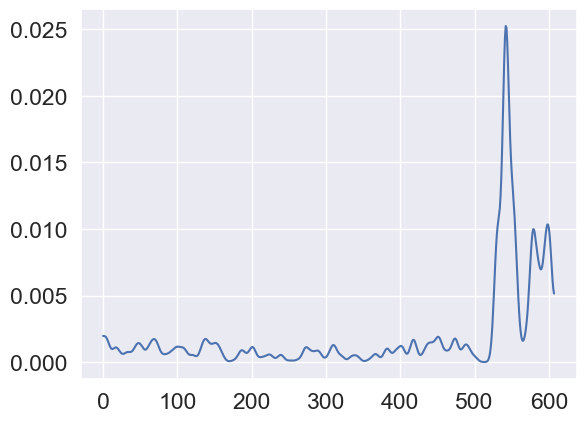

In [11]:
test_input = torch.from_numpy(x_test[:1]).float().to(survival_model.device)
test_input.requires_grad = True
gradient_of_input = get_receptive_field_mask(survival_model,test_input, last_feature_col_id=18,num_lead=0)
gradient_of_input = gaussian_filter1d(gradient_of_input, sigma=1)
print(gradient_of_input.shape)
## return the loc of receptive field with 1
plt.plot(gradient_of_input)
plt.show()



In [12]:
## smooth the upscaled attention
from scipy.ndimage.filters import gaussian_filter1d
import sys


def plot_time_attention_map_for_a_lead(lead_name,subject_index, whole_batch_input, time_attention,survival_model, ax=None,
                                       color_map="coolwarm",rescale_color=True,scatter_size=5,desired_sampling_rate=10000):
    
    lead_indice = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}[lead_name]
    input_signal =whole_batch_input[subject_index][lead_indice]
    lead_time_attention = time_attention[lead_indice][subject_indice]
    ## first normalize
    lead_time_attention = lead_time_attention.mean(axis=0)

    # sns.heatmap(lead_v2_time_attention.cpu().detach().numpy(),cmap="YlGnBu")
    max_seq_len = input_signal.shape[0]
    ## upscale the attention to the original signal length
    upscaled_attention = np.zeros(max_seq_len)
    for j in range(lead_time_attention.shape[-1]):
        input_signal_with_grad = torch.from_numpy(whole_batch_input[[subject_index]]).float().to(survival_model.device)
        input_signal_with_grad.requires_grad = True
        gradient_of_input = get_receptive_field_mask(survival_model, input_signal_with_grad, last_feature_col_id=j,num_lead=lead_indice)
        # gradient_of_input[gradient_of_input<=0]=0
        # gradient_of_input[gradient_of_input>0]=1
        gradient_of_input*=lead_time_attention[j]
        upscaled_attention+=gradient_of_input


    upscaled_attention =upscaled_attention[(608-600)//2:608-8//2]
    input_signal = input_signal[(608-600)//2:608-8//2]
    top_quantile = np.quantile(upscaled_attention,0.95)
    low_quantile = np.quantile(upscaled_attention,0.5)
    median_quantitle = np.quantile(upscaled_attention,0.75)
    max_seq_len = input_signal.shape[0]

    ## draw the signal using color sampled from the attention weight
    # if ax == None:
    #     plt.figure()
    #     fig = plt.plot(input_signal, color="black",linewidth=2)
    #     ## plot second line
    #     # plt.plot(upscaled_attention, color="red",linewidth=1,alpha=0.8)
    #     # ## plot region with color sampled from the attention weight
    #     # ## draw attention map as background color and remove the bounding box
    #     plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>0)&(upscaled_attention<=low_quantile)),color="red",alpha=0.05)
    #     plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention<median_quantitle)&(upscaled_attention>=low_quantile)),color="red",alpha=0.1)
    #     plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>=median_quantitle)&(upscaled_attention<top_quantile)),color="red",alpha=0.2)
    #     plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=(upscaled_attention>=top_quantile),color="red",alpha=0.5)
    #     plt.suptitle(lead_name)
    # else:
    #     fig = ax.plot(input_signal, color="black",linewidth=2)
    #     # ax.plot(upscaled_attention, color="red",linewidth=1,alpha=0.8)

    #     # ## plot region with color sampled from the attention weight
    #     # ## draw attention map as background color and remove the bounding box
    #     ax.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>0)&(upscaled_attention<=low_quantile)),color="red",alpha=0.05)
    #     ax.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention<median_quantitle)&(upscaled_attention>=low_quantile)),color="red",alpha=0.1)
    #     ax.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>=median_quantitle)&(upscaled_attention<top_quantile)),color="red",alpha=0.3)
    #     ax.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=(upscaled_attention>=top_quantile),color="red",alpha=0.5)
    #     ax.set_title(lead_name)
    ##  log
    # log_attention = np.log(upscaled_attention+1e-5)
    ax = vis_colored_lines(input_signal, upscaled_attention, ax=ax, title=lead_name,orig_sampling_rate=500,desired_sampling_rate=desired_sampling_rate,rescale_color=rescale_color, scatter_size=scatter_size,color_map=color_map)
    return ax
    ## remove bounding boxes

## remove ticks

/tmp/ipykernel_22179/1382606795.py:2: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import neurokit2 as nk

sns.set()

def vis_colored_lines(input_arr, color_arr, orig_sampling_rate, desired_sampling_rate=5000, 
                      scatter_size = 10,
                      rescale_color=False, x_axis_max=None, title=None, 
                      color_map='copper',ax=None,plot_colorbar=False):
    """
    Visualize a 1D signal with a color gradient.
    :param input_arr: array
        The input signal.
    :param color_arr: array
        The color signal.
    :param orig_sampling_rate: int
        The original sampling rate of the input signal.
    :param desired_sampling_rate: int
        The desired sampling rate of the input signal.
    :param scatter_size: int
        The size of the scatter plot.
    :param rescale_color: bool
        If True, rescale the color array.
    :param x_axis_max: int
        The maximum value of the x-axis.
    :param title: str
        The title of the plot.
    :param color_map: str
        The color map to use.
    :param ax: matplotlib axis
        The axis to plot on.
    :return: matplotlib axis
        The axis on which the plot was drawn.
    """

    if orig_sampling_rate < desired_sampling_rate:    
    # Resample the signal
        input_array = nk.signal_resample(input_arr, sampling_rate=orig_sampling_rate, desired_sampling_rate=desired_sampling_rate, method='interpolation')
        color_array = nk.signal_resample(color_arr, sampling_rate=orig_sampling_rate, desired_sampling_rate=desired_sampling_rate, method='interpolation')
    
    else:
        input_array = input_arr
        color_array = color_arr
    assert len(input_array) == len(color_array), "The length of the input array and the color array should be the same."
         # Preprocess ECG signal
    x_axis_max  =1 if x_axis_max is None else x_axis_max
    x = np.linspace(0,x_axis_max, input_array.shape[0])
    ## resclae
    if rescale_color:
        color_array = (color_array - np.min(color_array)) / (np.max(color_array) - np.min(color_array))
    else:
        color_array = color_array
    print(len(x), len(input_array), len(input_arr))
    if ax is None:
        fig, ax = plt.subplots()
        points = plt.scatter(x, input_array, c=cm.get_cmap(color_map)(color_array), edgecolor='none', s=scatter_size,alpha=0.5)
        ## plot a line
        plt.plot(x, input_array, color="black",linewidth=1)
    else:
        points = ax.scatter(x, input_array, c=cm.get_cmap(color_map)(color_array), edgecolor='none', s=scatter_size,alpha=0.5)
        ## plot a line
        ax.plot(x, input_array, color="black",linewidth=1)
    if ax is None:
        plt.title(title, y=1.0, pad=-14)
    else:
        ax.set_title(title,y=1.0, pad=-14)


    if plot_colorbar: plt.colorbar(cm.ScalarMappable(cmap=cm.get_cmap(color_map)))
    return ax


12000 12000 600


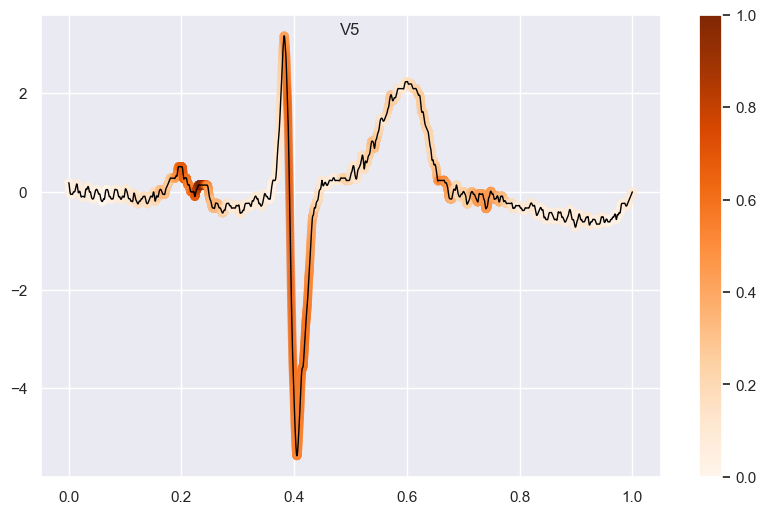

In [14]:
## MI: high risk id: 5363922, id = 10062
subject_indice = 124
## visualize time attention
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax = plot_time_attention_map_for_a_lead("V5",subject_indice, X, time_attantion_dict_flatten,survival_model, ax=ax, color_map="Oranges", scatter_size=40)
plt.colorbar(cm.ScalarMappable(cmap=cm.get_cmap("Oranges")))

[1.609408]


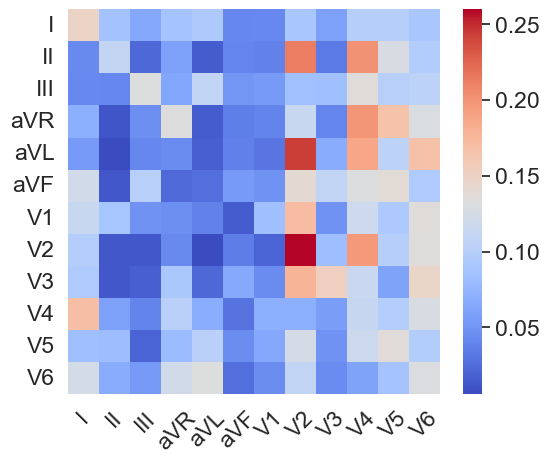

In [15]:
## visualize lead attention map:
#HYP high risk group: 1379
## low risk group: 1900

# high risk mi:
# subject_group = [702]#,783,572]

# low risk mi:
# subject_group = [319, 545,450]
## high risk hyp:
# subject_group  = [1379] #, 3066,3343]
## low risk hyp:
 #1900,3885,5167]
sns.set(font_scale=1.5)
index = 572

subject_attention_map  =lead_attention_sorted[index]
risk_score = total_risk_score_sorted[index]
print(risk_score)
get_report(index, y_eid_list,os.path.join(project_root_path,"data/ukb/ecg_report.csv"))
x_ticks = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
fig,ax = plt.subplots(1,1,figsize=(6,5))
g = sns.heatmap(subject_attention_map,cmap="coolwarm", xticklabels=x_ticks, yticklabels=x_ticks)
## rotate the xticklabels
ax.tick_params(axis='x', rotation=45)
## set up the 

12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600


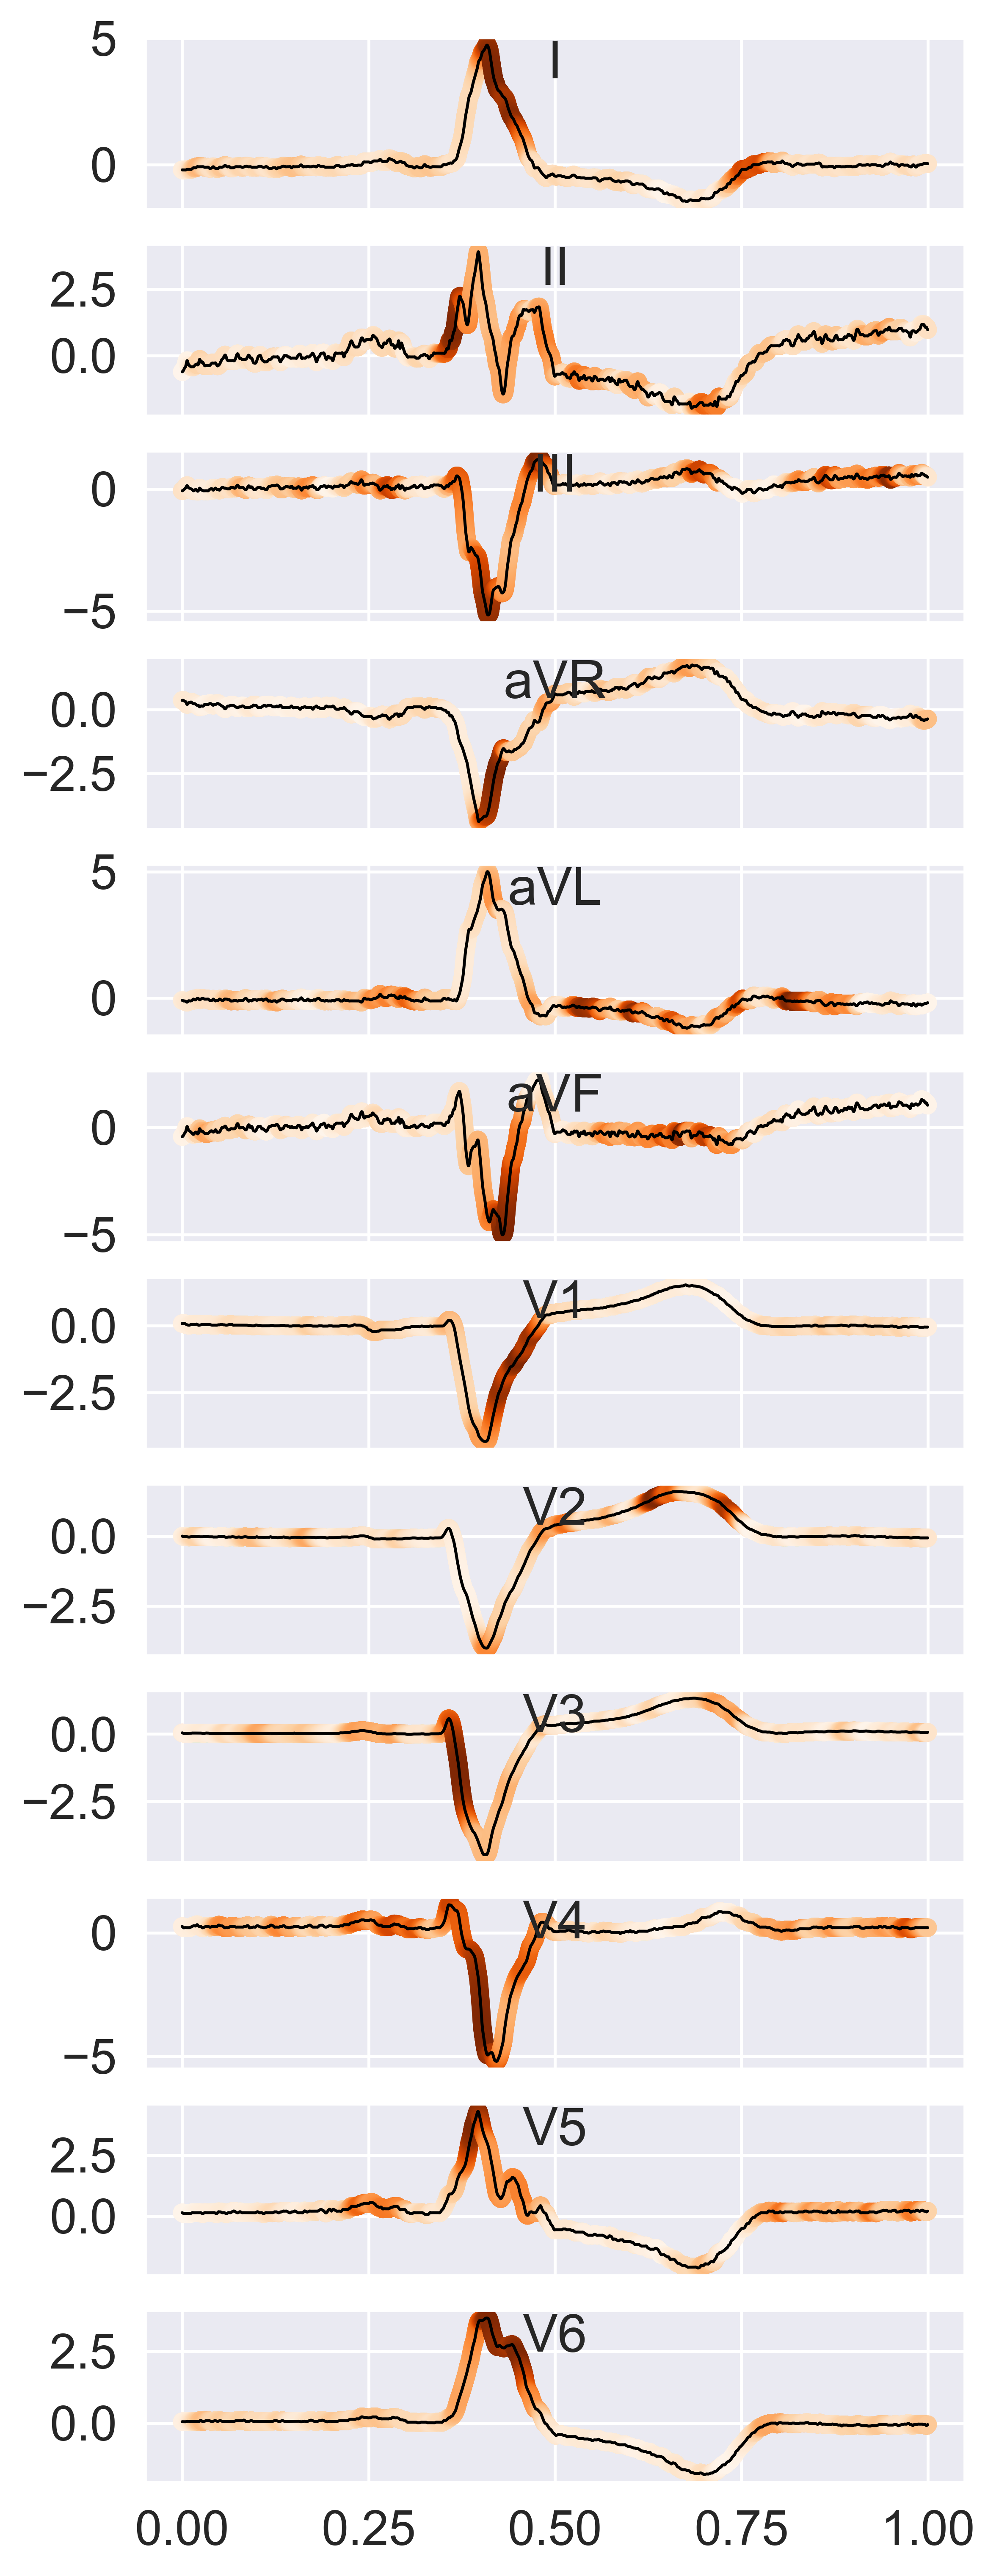

In [16]:

# high risk mi:
# subject_group = [702]#,783,237]

# low risk mi:
# subject_group = [319, 545,450]

## high risk hyp:
# subject_group  = [1379] #, 3066,3343]
## low risk hyp:
 #1900,3885,5167]
subject_group = [index]

lead_name_list =  ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
# lead_name_list =  ['I','aVF','V4']
## 'aVR','aVL','aVF',

fig, axes = plt.subplots(len(lead_name_list),len(subject_group), figsize=(5,15),squeeze=False,dpi=500, sharex=True)
for i, subject_indice in enumerate(subject_group):
    for j in range(len(lead_name_list)):
        lead_name = lead_name_list[j]
        plot_time_attention_map_for_a_lead(lead_name,subject_indice, X, time_attantion_dict_flatten,survival_model, ax=axes[j,i], color_map="Oranges",rescale_color=True, scatter_size=40)


In [17]:
get_report(index, y_eid_list,os.path.join(project_root_path,"data/ukb/ecg_report.csv"))

("['Sinus bradycardia', 'Left bundle branch block', 'Abnormal ECG', '---', 'Arrhythmia results of the full-disclosure ECG', 'QRS Complexes: 13']",
 "['Sinus bradycardia', 'Left bundle branch block', 'Abnormal ECG', '---', 'Arrhythmia results of the full-disclosure ECG', 'QRS Complexes: 13']")

12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600
12000 12000 600


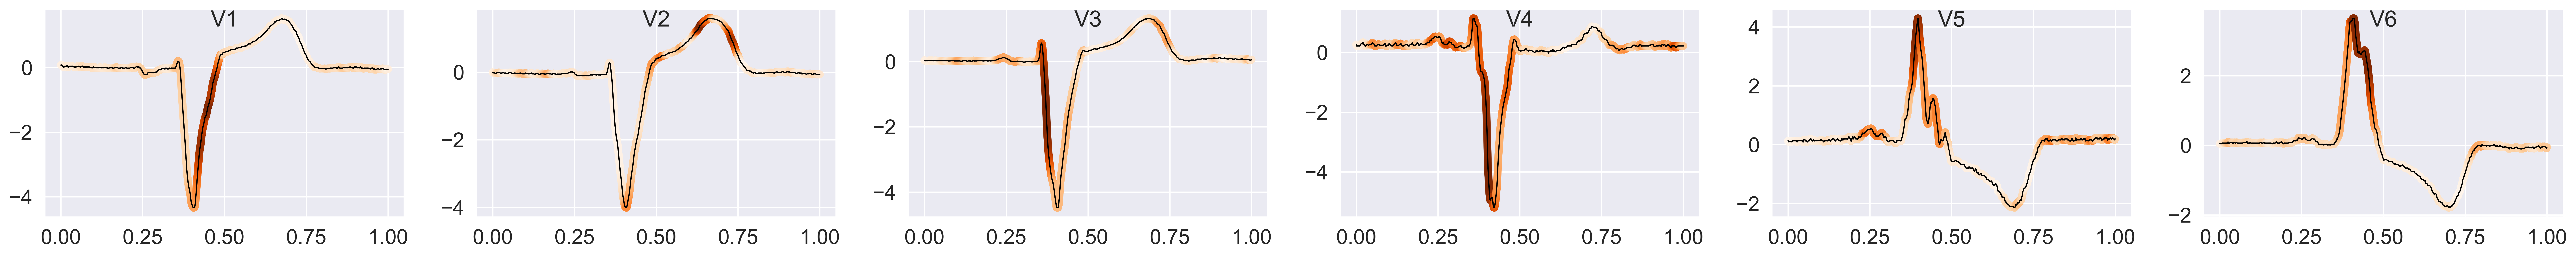

In [18]:
lead_name_list = ['V1','V2','V3','V4','V5','V6']

fig, axes = plt.subplots(len(subject_group),len(lead_name_list), figsize=(36,3),squeeze=False,dpi=500)
for i, subject_indice in enumerate(subject_group):
    for j in range(len(lead_name_list)):
        lead_name = lead_name_list[j]
        plot_time_attention_map_for_a_lead(lead_name,subject_indice, X, time_attantion_dict_flatten,survival_model, ax=axes[i,j],color_map="Oranges",rescale_color=True, scatter_size=40)
